# Library Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import numpy as np
import gvar as gv
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(1, '../')
from building_blocks_reader import bulding_block

In [2]:
#!pip install -e /wsgjsc/home/taggi1/workspace_folders/CorrelatorAnalyser

In [3]:
#!pip install mplStyle

## Pasted from available code

In [4]:
# from dataclasses import dataclass
# from pathlib import Path
# import json
# import itertools
# import h5py as h5 
# import numpy as np
# import gvar as gv
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator

# import json
# from tqdm import tqdm

# import sys

# #sys.path.insert(1, '../../CorrelatorAnalyser')
# sys.path.insert(1, '/wsgjsc/home/taggi1/workspace_folders/CorrelatorAnalyser')


# import correlatoranalyser as ca

# #from lib_ensembleDetails import EnsembleDetails

# #from mplStyle import *

# # %matplotlib ipympl
# %matplotlib inline

# markers = [".","+","^","s","p","*","h","v","x","<",">","D","o"]
# linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0,(1,10)), (5,(10,13))]

In [5]:
#with h5.File("Cache/D251_Nbst100.h5", 'r') as h5f:
#    params = json.loads(
#        h5f["Meta"][()]
#    )

# # I want to adept some naming conventions
# params["C2pt fit"] = {
#     "shared": {
#         "min interval start": 1,
#         "interval end"      : 50,
#         "interval step"     : 4,
        
#         "max number states": 2,
#         "model" : "sum of ordered exponentials",
        
#         "central value fit": True,            
#         "central value fit correlated": False, 
#         "resample fit": True,     
#         "resample fit correlated": False,      
#         "resample prior": False,

#         "prior strategy": {
#             "Eeff": {
#                 "estimate range start": 15,
#                 "estimate range stop" : 50
#             },
#             "std scale": 3,
#             "mpi": gv.gvar("0.09203(16)")
#         }
#     }
# }

In [33]:
a = 0.1163

0.09203 /a * 197.327


m_prot = 1000 * a / 197.327
m_prot

156.14792613929492

0.5893770239247543

In [6]:
# def effective_energy(C2pt, q2):
#     logC = np.log(np.abs(C2pt[q2]))
    
#     E_eff = 0.5*( np.roll(logC, +1, axis=-1) - np.roll(logC, -1, axis=-1 ) )[...,1:-1]

#     return E_eff

#Eeff_unpolarized = {
#    f"q2: {q2}": effective_energy(C2pt_unpolarized, q2)
#        for q2 in range(params["maximal momentum squared"]+1)
#}

In [7]:
class SumOrderedExponentials:
    def __init__(self, number_states):
        self.number_states = number_states

    def __call__(self,t,p):
        E = p["E0"]
        out = p[f"A{0}"] * np.exp( -t*E )
    
        for n in range(1,self.number_states):
            #    ΔE_n = E_n - E_{n-1}
            # =>  E_n = E_{n-1} + ΔE_n
            E += p[f"dE{n}"]
    
            out += p[f"A{n}"] * np.exp( -t*E )
    
        return out

In [8]:
def model_average_prior(fit_state, key, fit_task):
    r"""

    """
    
    # determine if we desire a log prior
    log_prior = 'log' in key

    # prepare the key to access the exponentiated result extracted of the model average
    if log_prior:
        key = key[4:-1]

    # compute the model average
    model_average = fit_state.model_average()

    # ensure that the key is in the model average and if not return a flat prior
    if key not in model_average['est'].keys():
        raise RuntimeError(f"{key} not yet fitted, choose different prior strategy")

    # prior rule: N( <p>, X*std(p) )
    prior = gv.gvar(
        model_average['est'][key],
        #np.maximum(
        #    Args['est']["A00"],
        model_average['err'][key] * fit_task["prior strategy"]["std scale"]
        #)
    )

    if log_prior:
        return gv.log(prior)
    else:
        return prior


def prior_sum_ordered_exponentials(NumberStates, q2, params, **kwargs):
    prior = gv.BufferDict()

    if f"q2: {q2}" in params["C2pt fit"].keys():
        fit_task = params["C2pt fit"][f"q2: {q2}"]
    else:
        fit_task = params["C2pt fit"]["shared"]    
    
    if "fit_state" in kwargs.keys():
        fit_state = kwargs["fit_state"]
            
        prior["A0"] = model_average_prior(fit_state = fit_state, key = "A0", fit_task = fit_task)
        prior["E0"] = model_average_prior(fit_state = fit_state, key = "E0", fit_task = fit_task)
        
        for n in range(1,NumberStates):
            for key in [f"dE{n}", f"A{n}"]:
                if key not in fit_state.keys_all:
                    prior[key] = gv.gvar(1,1000)
                else:
                    prior[key] = model_average_prior(fit_state = fit_state, key = key, fit_task = fit_task)
                
        return prior

    linear_fit_result = one_state_solution[f"q2: {q2}"].result_params()
    
    prior["A0"] = gv.gvar(
               np.exp( gv.mean(linear_fit_result["est"]["ln(A0)"])),
        np.std(np.exp( gv.mean(linear_fit_result["res"]["ln(A0)"])), axis =0 ) * fit_task["prior strategy"]["std scale"]
    )
    prior["E0"] = gv.gvar(
        linear_fit_result["est"]["E0"],
        linear_fit_result["err"]["E0"] * fit_task["prior strategy"]["std scale"]
    )

    C = C2pt_unpolarized[q2]
    C = gv.gvar( np.mean(C,axis=0), np.std(C,axis=0) ) 

    for n in range(1,NumberStates):
        
        if n == 1:
            prior[f"log(dE1)"]= gv.log(gv.gvar(
                gv.mean(prior[f"E0"] + fit_task["prior strategy"]["mpi"]),
                gv.mean(prior[f"E0"] + fit_task["prior strategy"]["mpi"]),
            ))

            t_probe = 1
            tmp = (C[t_probe] - prior["A0"] * np.exp(-t_probe*prior["E0"]) ) * np.exp( t_probe * ( prior["dE1"] + prior["E0"]) )
            prior[f"A1"] = gv.gvar( 
                gv.mean(tmp),gv.mean(tmp)
            )
        else:
            prior[f"A{n}"] = gv.gvar(1,1000)
            prior[f"log(dE{n})"] = gv.log(gv.gvar(1,1))

    return prior

models = {
    "sum of ordered exponentials": (SumOrderedExponentials, prior_sum_ordered_exponentials),
}

In [9]:
def fit_C2pt(C2pt, q2, params, pbar):
    if f"q2: {q2}" in params["C2pt fit"].keys():
        fit_task = params["C2pt fit"][f"q2: {q2}"]
    else:
        fit_task = params["C2pt fit"]["shared"]

    fit_state = ca.FitState()

    C = C2pt[q2] 
    
    for number_states in range(1, fit_task["max number states"]+1):
        number_params = 2 * number_states

        model = models[fit_task["model"]][0](number_states)

        num_fits = 0 
        for ts in range(fit_task["min interval start"], fit_task["interval end"], fit_task["interval step"]):
            if (fit_task["interval end"]-ts <= number_params+2 ): continue
            
            te = fit_task["interval end"]

            if num_fits > 4:
                prior = models[fit_task["model"]][1](number_states, q2, params, fit_state = fit_state)
            else:
                prior = models[fit_task["model"]][1](number_states, q2, params)

            if number_states == 1:
                fit_result = ca.linear_regression(
                    abscissa                = np.arange(ts,te),
                    ordinate_est            = np.mean(np.log(np.abs(C[:,ts:te])), axis = 0),
                    ordinate_std            = np.std (np.log(np.abs(C[:,ts:te])), axis = 0),
                    ordinate_cov            = np.cov (np.log(np.abs(C[:,ts:te])), rowvar=False),
                    resample_ordinate_est   = np.log(np.abs(C[:,ts:te])),
                    resample_ordinate_std   = np.std (np.log(np.abs(C[:,ts:te])), axis = 0),
                    resample_ordinate_cov   = np.cov (np.log(np.abs(C[:,ts:te])), rowvar=False),
                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = fit_task["central value fit"],
                    central_value_fit_correlated = fit_task["central value fit correlated"],
                    resample_fit                 = fit_task["resample fit"],
                    resample_fit_correlated      = fit_task["resample fit correlated"],
                    resample_type               = "bst" if params["bootstrap"] else "jkn",
                    
                    has_intercept = True,
                    parameter_names = ["E0", "log(A0)"]
                )
                fit_result.fcn = SumOrderedExponentials(number_states = 1)
                
            else:
                fit_result = ca.fit(
                    abscissa                = np.arange(ts,te),
                    ordinate_est            = np.mean(C[:,ts:te], axis = 0),
                    ordinate_std            = np.std (C[:,ts:te], axis = 0),
                    ordinate_cov            = np.cov (C[:,ts:te], rowvar=False),
                    resample_ordinate_est   = C[:,ts:te],
                    resample_ordinate_std   = np.std (C[:,ts:te], axis = 0),
                    resample_ordinate_cov   = np.cov (C[:,ts:te], rowvar=False),
                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = fit_task["central value fit"],
                    central_value_fit_correlated = fit_task["central value fit correlated"],
                    resample_fit                 = fit_task["resample fit"],
                    resample_fit_correlated      = fit_task["resample fit correlated"],
                    resample_fit_resample_prior  = fit_task["resample prior"],
                    resample_type               = "bst" if params["bootstrap"] else "jkn",
                    # args for lsqfit:
                    model   = model,
                    prior   = prior,
                    p0      = None,
                    svdcut  = None,
                    maxiter = 10_000,
                )

            num_fits+=1

            pbar.write(f"{fit_result}")

            fit_state.append(fit_result)
            pbar.update()
        # end for ts
    # end for number_states
    return fit_state

# Data Reading

In [10]:
#folders where the dataset is
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/3PointCorrelation/T6/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW/2PointCorrelation/"

#instance of the building block class
bb = bulding_block(p3fold,p2fold, maxConf=100, verbose=True, skip3p=True)


Initializing the building block class instance...


Looping over the configurations to read the building blocks from the h5 files...


Looping over the configurations to read the 2-point correlators from the h5 files...



100%|██████████| 100/100 [00:01<00:00, 62.46it/s]


In [11]:
bb.latticeT

times = np.arange(bb.latticeT)

48

In [12]:
p2corr = bb.p2_corr.real

np.shape(p2corr)

(100, 48)

In [13]:
#fit parameters

# abscissa = arange(t_start_plateau, t_end_plateau)

# ordinate_est = mean(p2corr, axis=cfg )    #-----> everything performed on log of abs of p2corr, not p2corr itself, if regression is used instead of fit
# ordinate_std = std(p2corr, axis=cfg ) 
# ordinate_cov = cov(p2corr, axis=cfg ) 

# resample_ordinate_est = p2corr #----------> axis 0 = cfg or axis 0 = resample ???
# resample_ordinate_std = ordinate_std
# resample_ordinate_cov = ordinate_cov

# central_value fit = bool, related to type of fit (True by default)
# central_value_fit_correlated = bool, related to type of fit (False by default)

# resample_fit                 =  bool, related to type of fit (False by default)
# resample_fit_correlated      =  bool, related to type of fit (False by default)

# resample_fit_resample_prior  =  bool, related to type of fit (True by default) #----> might want to put that to False to make running time shorter while developing
# resample_type               = "bst" if bootstrap is used else "jkn" if jackknife is used

# model = function taking as input abscissa and fit params

# prior = prior estimate of fit params

# p0 = start value of fit params

# maxiter = max n of iterations for the fit

# svdcut = ???

In [14]:
#params["C2pt fit"] = {
#    "shared": {
#        "min interval start": 1,
#        "interval end"      : 50,
#        "interval step"     : 4,
#        
#        "max number states": 2,
#        "model" : "sum of ordered exponentials",
#        
#        "central value fit": True,            
#        "central value fit correlated": False, 
#        "resample fit": True,     
#        "resample fit correlated": False,      
#        "resample prior": False,
#
#        "prior strategy": {
#            "Eeff": {
#                "estimate range start": 15,
#                "estimate range stop" : 50
#            },
#            "std scale": 3,
#            "mpi": gv.gvar("0.09203(16)")
#        }
#    }
#}

In [15]:
#ca.fit(abscissa=times)

# Effective Mass Plateau

In [16]:
from moments_toolkit import effective_mass, jackknife, plateau_search

In [17]:
#we determine log of 2p corr using the jackknife
p2corr_jack, p2corr_jack_std, p2corr_jack_cov = jackknife(p2corr, lambda x: np.mean( x, axis=0), jack_axis=0, time_axis=-1)

np.shape(p2corr_jack)
np.shape(p2corr_jack_std)
np.shape(p2corr_jack_cov)

(48,)

(48,)

(48, 48)

In [18]:
#we use the jackknife to compute the effective mass (mean and std)
meff_raw, meff_std_raw, meff_covmat_raw = jackknife(p2corr, effective_mass, jack_axis=0, time_axis=-1) #raw becaus there still are values of the mass that are 0


#we look at the point where the mass starts to be negative
cut=np.where(meff_std_raw<=0)[0][0]

#and we cut the meff arrays there
meff = meff_raw[:cut]
meff_std = meff_std_raw[:cut]
meff_covmat = meff_covmat_raw[:cut,:cut]



#first we identify the boundaries of the plateau region
start_plateau, end_plateau = plateau_search(meff, meff_covmat, chi2_treshold=1.0)
start_plateau, end_plateau


#we define the gaussian var eff_mass
gv_meff = gv.gvar(meff[start_plateau:end_plateau], meff_std[start_plateau:end_plateau])
gv_meff_mean = np.mean(gv_meff)

gv_meff
gv_meff_mean


#then we get the mass from the plateau value
#meff_plat = np.average(meff[start_plateau:end_plateau], np.diag(meff_covmat[start_plateau:end_plateau]))
#its std is given by sqrt of sum variance/ N
#meff_plat_std = np.sqrt( np.mean( meff_std[start_plateau:end_plateau]**2 ) )

(7, 19)

array([0.5697(82), 0.545(12), 0.544(15), 0.534(19), 0.530(43), 0.535(51),
       0.462(73), 0.537(87), 0.50(12), 0.50(18), 0.45(29), 0.13(61)],
      dtype=object)

0.486(60)

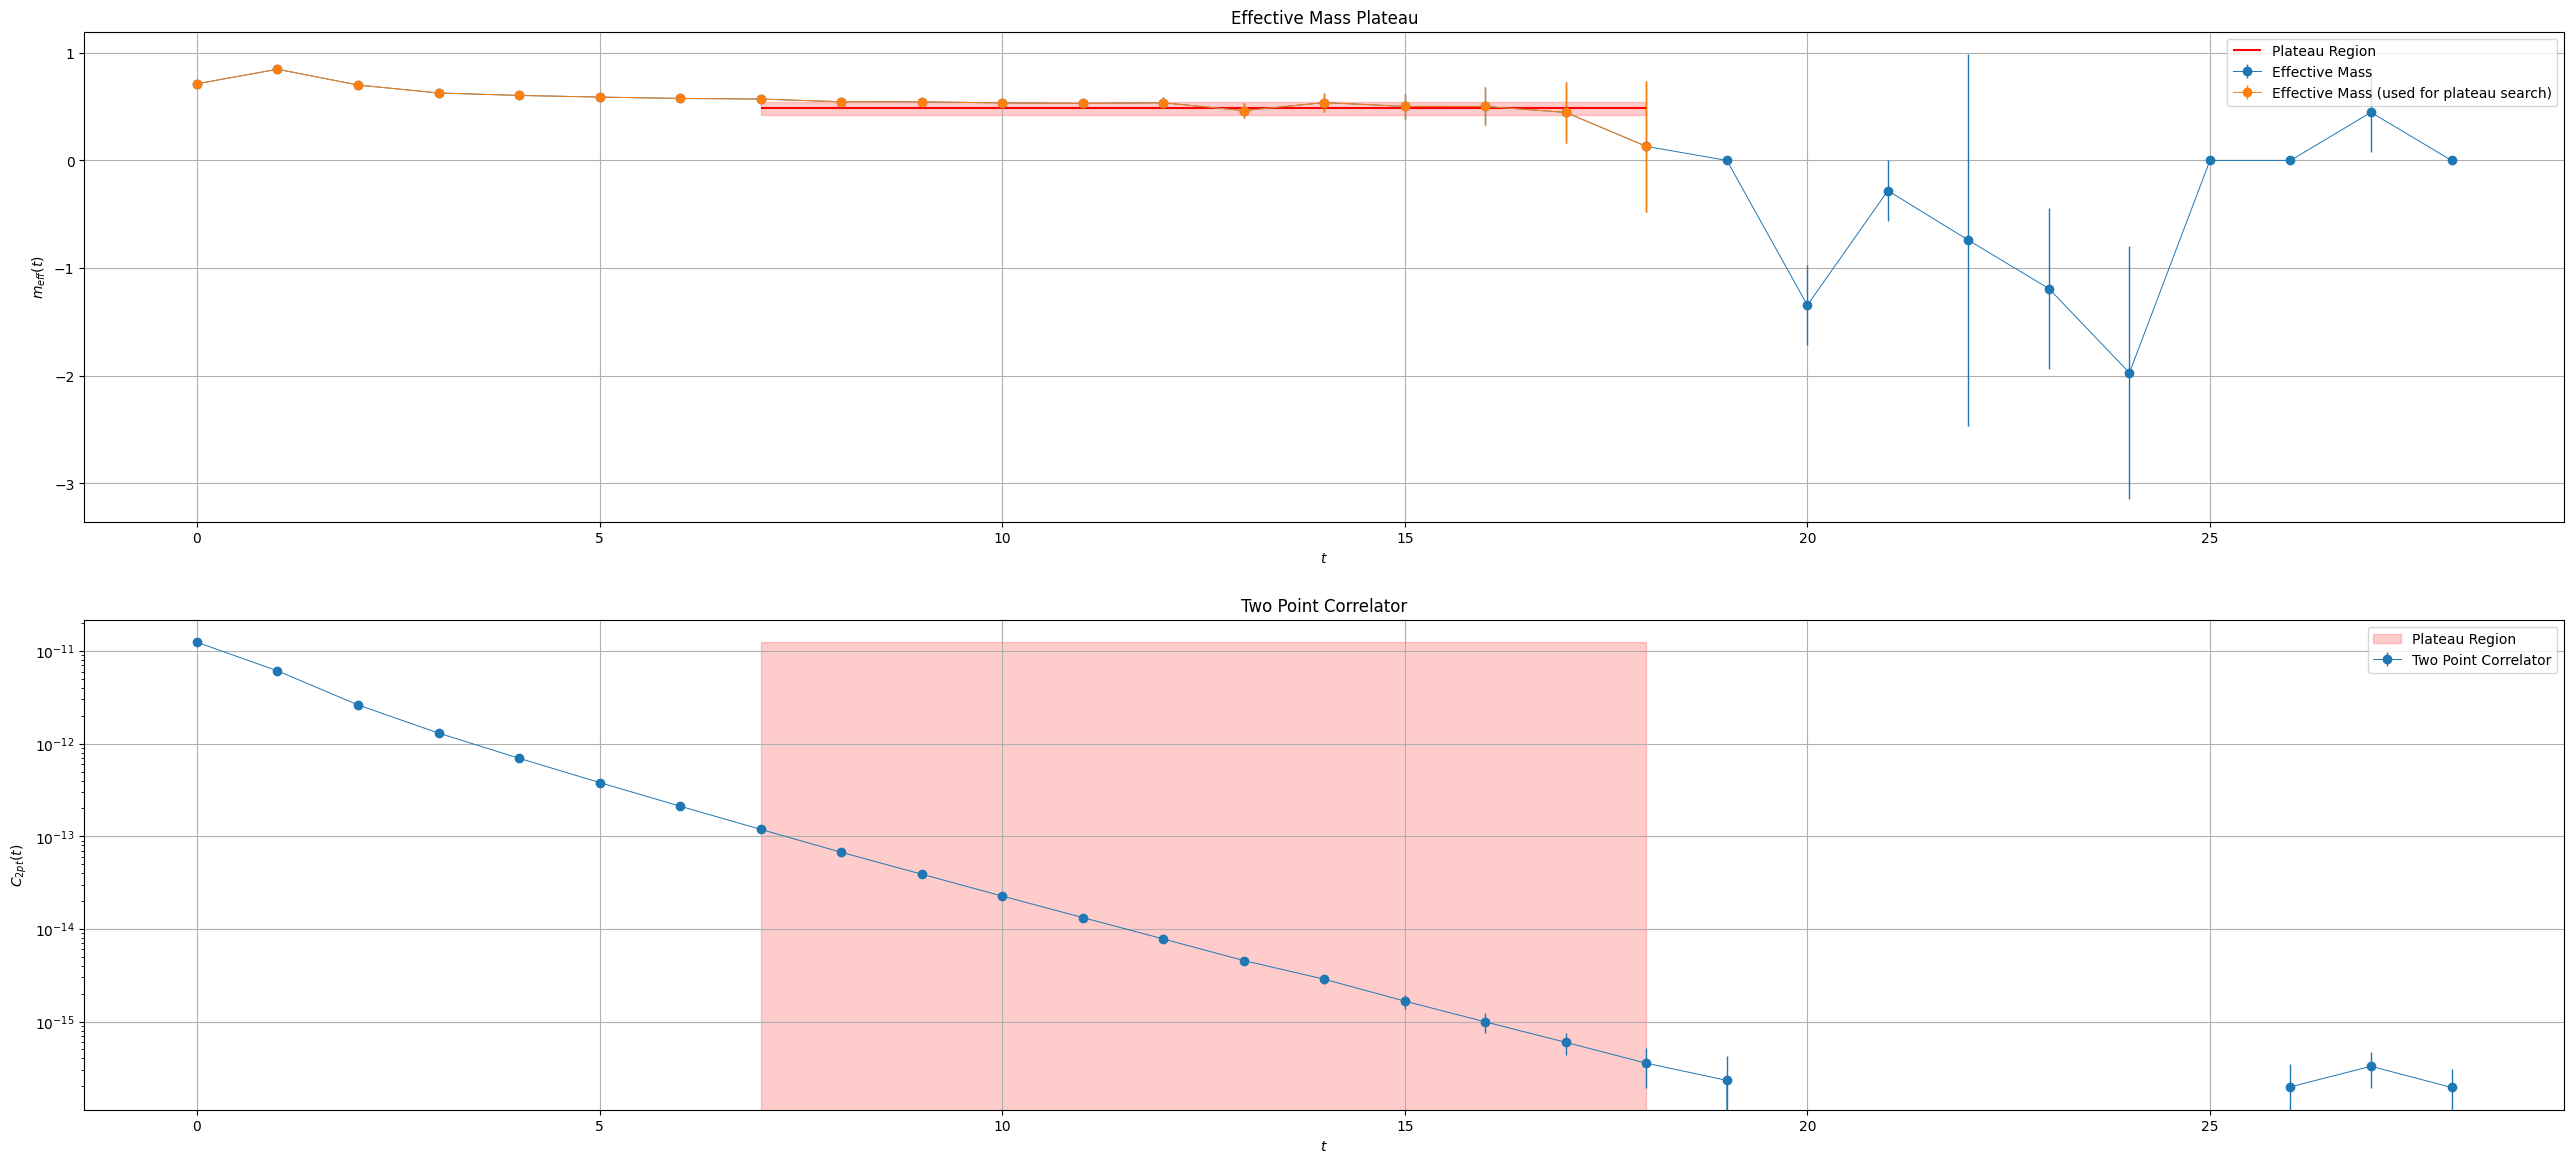

In [19]:
#we make a plot

#we instantiate the figure
fig, axlist = plt.subplots(nrows=2,ncols=1,figsize=(32, 14))

ax1 = axlist[0]


#we determine the time values to be displayed on the plot (x axis)
m_times = np.arange(np.shape(meff_raw)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
zoom = 10

start_plot = start_plateau-zoom if start_plateau-zoom > 0 else 0

#we plot the plateau and the neighbouring effective mass values
_ = ax1.errorbar(m_times[start_plot:end_plateau+zoom], meff_raw[start_plot:end_plateau+zoom], yerr=meff_std_raw[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass")
_ = ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
_ = ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax1.fill_between(m_times[start_plateau:end_plateau], gv_meff_mean.mean - gv_meff_mean.sdev, gv_meff_mean.mean + gv_meff_mean.sdev, alpha=0.2, color="red")

#plot styling
_ = ax1.set_title("Effective Mass Plateau")
_ = ax1.set_ylabel(r"$m_{eff}(t)$")
_ = ax1.set_xlabel(r"$t$")
_ = ax1.grid()
_ = ax1.legend()





ax2 = axlist[1]


#we determine the time values to be displayed on the plot (x axis)
times = np.arange(np.shape(p2corr_jack)[0]) #+ 0.5

#we decide how much we want to zoom out of the plateau
#zoom = 7

#we plot the plateau and the neighbouring effective mass values
_ = ax2.errorbar(times[start_plot:end_plateau+zoom], p2corr_jack[start_plot:end_plateau+zoom], yerr=p2corr_jack_std[start_plot:end_plateau+zoom], linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Two Point Correlator")
#ax1.errorbar( np.arange(np.shape(meff)[0]), meff, yerr=meff_std, linewidth=0.7, marker='o', markersize=6, elinewidth=1.0, label="Effective Mass (used for plateau search)")
#ax1.hlines(gv_meff_mean.mean, start_plateau, end_plateau-1, color='red', label="Plateau Region")
#plt.hlines(meff_plat + meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
#plt.hlines(meff_plat - meff_plat_std, start_plateau+0.5, end_plateau+0.5, color='red', linestyles='dashed')
_ = ax2.fill_between(times[start_plateau:end_plateau], np.min(p2corr_jack[start_plot:end_plateau+zoom]), np.max(p2corr_jack[start_plot:end_plateau+zoom]), alpha=0.2, color="red", label="Plateau Region")

#plot styling
_ = ax2.set_title("Two Point Correlator")
_ = ax2.set_ylabel(r"$C_{2pt}(t)$")
_ = ax2.set_xlabel(r"$t$")
_ = ax2.set_yscale("log")
_ = ax2.grid()
_ = ax2.legend()

# 2 Point Correlator Fit

In [50]:
import correlatoranalyser as ca

In [51]:
t_end = end_plateau # - 1
t_start = start_plateau

t_start, t_end

(7, 19)

In [52]:
#creation of jackknife resamples
binsize=1
jack_axis=0
first_conf=0
last_conf = np.shape(p2corr)[jack_axis]


#step 1: creation of the jackknife resamples
p2corr_resamples = np.asarray( [np.delete(p2corr, list(range(iconf,min(iconf+binsize,last_conf))) ,axis=jack_axis).mean(axis=0) for iconf in range(first_conf,last_conf,binsize)] ) #shape = (nresamp,) + shape(in_array) (with nconf -> nconf-binsize)

np.shape(p2corr_resamples)

(100, 48)

In [53]:
class SumOrderedExponentials:
    def __init__(self, number_states):
        self.number_states = number_states

    def __call__(self,t,p):
        E = p["E0"]
        out = p[f"A{0}"] * np.exp( -t*E )
    
        for n in range(1,self.number_states):
            #    ΔE_n = E_n - E_{n-1}
            # =>  E_n = E_{n-1} + ΔE_n
            E += p[f"dE{n}"]
    
            out += p[f"A{n}"] * np.exp( -t*E )
    
        return out

In [54]:
from scipy.optimize import curve_fit

#exponential function used in the fit for the mass extraction
def exp_fit_func(t: np.ndarray, amp: float, mass: float) -> np.ndarray:
    """
    This function is only used to fit the two point correlators to an exponential to extract the mass using scipy curve fit
    
    Input:
        - t: numpy array with the times (the x array of the fit)
        - amp: the amplitude of the exponential
        - mass: the mass at the exponent (the parameter we actually want to extract from the fit)
        
    Output:
        - corr_2p(t) = amp * exp(-t * m): the values of the correlator in the purely exponential form (the y array of the fit)
    """
    
    #we just return the exponential
    return amp * np.exp(-t * mass)

#function used to extract the fit mass from the two-point correlators
def fit_mass(corr_2p: np.ndarray, conf_axis:int=0, par="mass") -> np.ndarray:
    """
    Input:
        - corr_2p: two point correlators, with shape (nconf, Tlat) (with Tlat being the time extent of the lattice)
        - conf_axis: the axis with the configurations
        - guess_mass: the first guess for the mass we want to extract from the fit

    Output:
        - (mift, mfit_std): the mean value and the std of the mass extracted from the fit
    """



    #we first take the gauge average of the two point correlator
    corr_gavg = np.mean(corr_2p, axis=conf_axis)

    #then we define the first guess for the parameters of the fit
    guess_amp = corr_gavg[0]
    guess_mass = np.log( corr_gavg[0]/corr_gavg[1] )
    guess = [guess_amp,guess_mass]

    #we define the x and y arrays used for the fit (which are respectively times and corr_gavg)
    times = np.arange(np.shape(corr_gavg)[conf_axis])

    #we perform the fit
    popt,pcov = curve_fit(exp_fit_func, times, corr_gavg, p0=guess)#,maxfev = 1300) #popt,pcov being mean and covariance matrix of the parameters extracted from the fit
    perr = np.sqrt(np.diag(pcov)) #perr being the std of the parameters extracted from the fit

    #we read the mass (that's the only thing we're interested about, the amplitude we discard)
    fit_mass = np.array( popt[1 ] )
    fit_mass_std = np.array( perr[1] )

    #same thing for amplitude
    fit_amp = np.array( popt[0] )
    fit_amp_std = np.array( perr[0] )


    if par=="mass":
        #we return the fit mass and its std
        return fit_mass#, fit_mass_std, fit_amp, fit_amp_std 
    elif par=="amp":
        return fit_amp
    
mfit, mfit_std , _= jackknife(p2corr, lambda x: fit_mass(x,par="mass"), jack_axis=0, time_axis=None)
Afit, Afit_std , _= jackknife(p2corr, lambda x: fit_mass(x,par="amp"), jack_axis=0, time_axis=None)

In [55]:
Afit
mfit
mfit_std
m_prot

np.float64(1.2483611834502596e-11)

np.float64(0.7422343424855233)

np.float64(0.002133882470217956)

0.5893770239247543

In [56]:
prior = gv.BufferDict()

prior["A0"] = gv.gvar(Afit,Afit_std * 10)
prior["E0"] = gv.gvar(mfit, mfit_std * 10)
#prior["A1"] = gv.gvar(1,1000)
#prior["log(dE1)"] = gv.log(gv.gvar(1,1))


prior[f"log(dE1)"]= gv.log(gv.gvar(
            gv.mean(m_prot),
            gv.mean(m_prot),
        ))

t_probe = 1
tmp = (np.mean(p2corr,axis=0)[t_probe] - prior["A0"] * np.exp(-t_probe*prior["E0"]) ) * np.exp( t_probe * ( prior["dE1"] + prior["E0"]) )
prior[f"A1"] = gv.gvar( 
    gv.mean(tmp),gv.mean(tmp)
)       

In [65]:
fit_result = ca.fit(

                    abscissa                = np.arange(t_start,t_end),
                    
                    ordinate_est            = np.mean(p2corr_resamples[:,t_start:t_end], axis = 0),
                    ordinate_std            = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    ordinate_cov            = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),
                    
                    resample_ordinate_est   = p2corr_resamples[:,t_start:t_end],
                    resample_ordinate_std   = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    resample_ordinate_cov   = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = True,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "jkn",

                    # args for lsqfit:
                    model   = SumOrderedExponentials(2),
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
)


fit_result = ca.fit(

                    abscissa                = np.arange(t_start,t_end),
                    
                    ordinate_est            = np.mean(p2corr[:,t_start:t_end], axis = 0),
                    ordinate_std            = np.std (p2corr[:,t_start:t_end], axis = 0),
                    ordinate_cov            = np.cov (p2corr[:,t_start:t_end], rowvar=False),
                    
                    #resample_ordinate_est   = p2corr_resamples[:,t_start:t_end],
                    #resample_ordinate_std   = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    #resample_ordinate_cov   = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "jkn",

                    # args for lsqfit:
                    model   = SumOrderedExponentials(2),
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
)

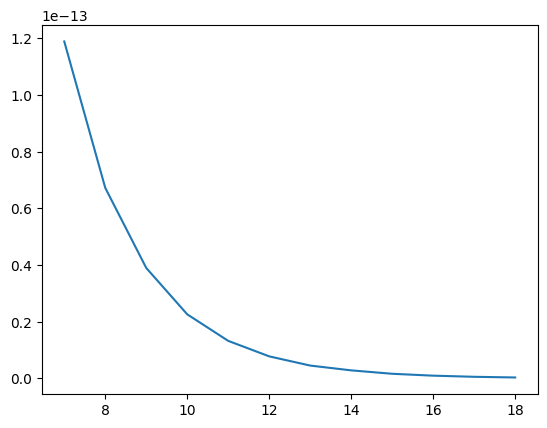

In [66]:
plt.plot(np.arange(t_start,t_end), np.mean(p2corr_resamples[:,t_start:t_end], axis = 0))

In [67]:
#dir(ca.FitResult)

fit_result.result_params(key="est")
fit_result.result_params(key="err")

fit_result.result_params

BufferDict({'A0': np.float64(1.3230130564902643e-11), 'E0': np.float64(0.6812648676046014), 'dE1': np.float64(0.5738222171825301), 'A1': np.float64(6.46115279881296e-13)})

BufferDict({'A0': np.float64(7.771802962302542e-13), 'E0': np.float64(0.012697339789410601), 'dE1': np.float64(0.5737354018567519), 'A1': np.float64(6.423615904727965e-13)})

<bound method FitResult.result_params of FitResult[ (7,18), resample:False]:
  𝜒²/dof [dof] = 1.27 [12]
  AIC = 4.93 
    - A0: 1.323(78)e-11  [1.248(82)e-11]
    - E0: 0.681(13)  [0.742(21)]
    - dE1: 0.57(57)  [0.59(59)]
    - A1: 6.5(6.4)e-13  [6.4(6.4)e-13]
>

In [ ]:
fit_result.result_params

fit_result.result_params()["est"].keys()


type(fit_result.best_fit_param_res)

<bound method FitResult.result_params of FitResult[ (7,18), resample:False]:
  𝜒²/dof [dof] = 1.27 [12]
  AIC = 4.93 
    - A0: 1.323(78)e-11  [1.248(82)e-11]
    - E0: 0.681(13)  [0.742(21)]
    - dE1: 0.57(57)  [0.59(59)]
    - A1: 6.5(6.4)e-13  [6.4(6.4)e-13]
>

KeysView(BufferDict({'A0': np.float64(1.3230130564902643e-11), 'E0': np.float64(0.6812648676046014), 'dE1': np.float64(0.5738222171825301), 'A1': np.float64(6.46115279881296e-13)}))

NoneType

In [68]:
m_prot

0.5893770239247543

In [72]:
C = gv.gvar( np.mean(p2corr_resamples[:,fit_result.ts:fit_result.te], axis = 0), np.sqrt( np.shape(p2corr_resamples)[0] - 1 ) * np.std(p2corr_resamples[:,fit_result.ts:fit_result.te], axis = 0)) #std has  jack prefactor

C = gv.gvar( np.mean(p2corr[:,fit_result.ts:fit_result.te], axis = 0), np.std(p2corr[:,fit_result.ts:fit_result.te], axis = 0))

<ErrorbarContainer object of 3 artists>

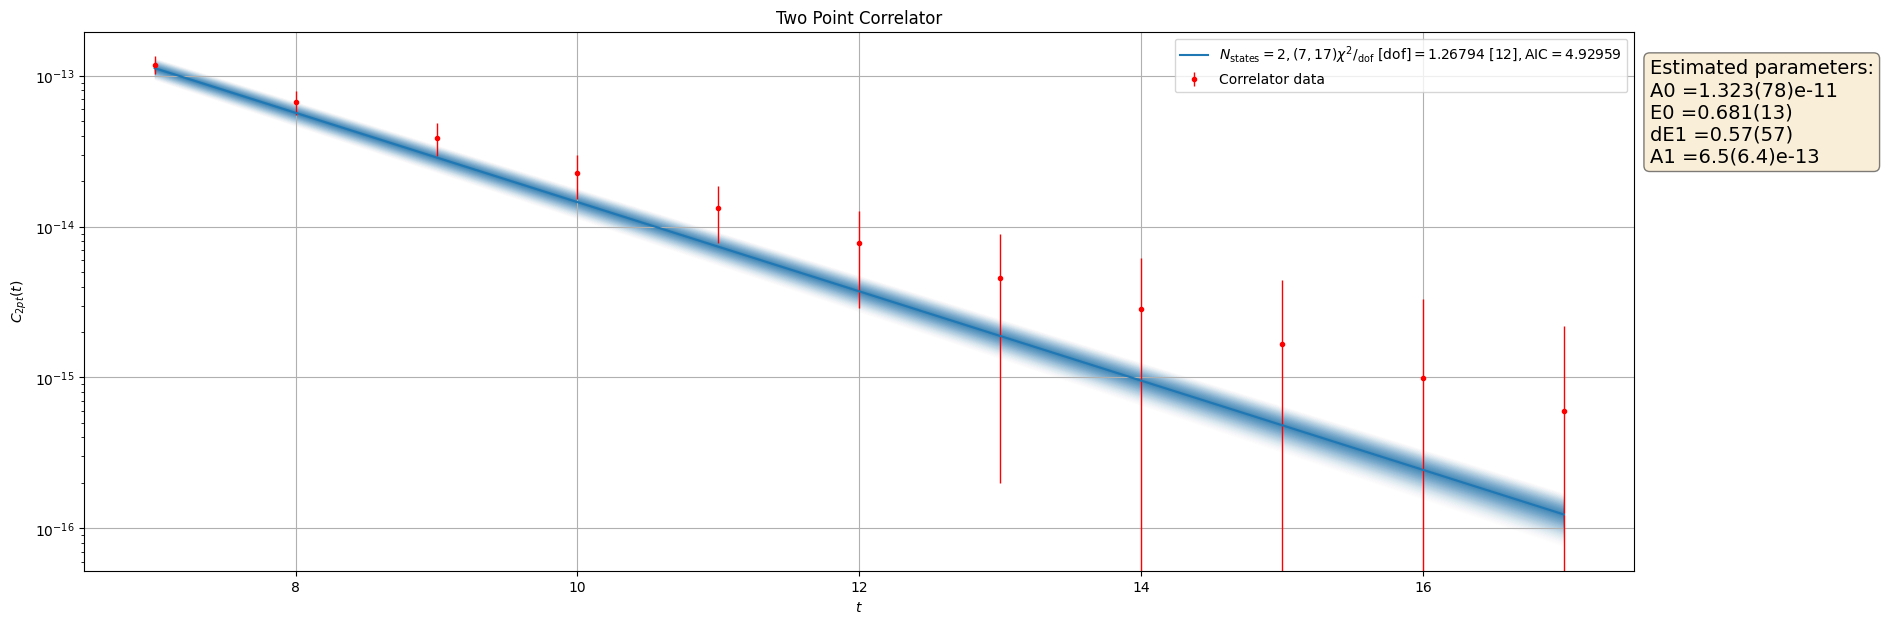

In [137]:
abscissa = np.arange(fit_result.ts, fit_result.te)
ordinate = fit_result.eval(abscissa)
#nstates = fit_result.fcn.Nstates
nstates=2

fig, axs = plt.subplots(1, 1, figsize=(20, 7))

# np.arange(t_start,t_end)
# np.arange(fit_result.ts,fit_result.te)
# abscissa

axs.errorbar(
        x=abscissa, y=gv.mean(C), yerr=gv.sdev(C), marker='.', linewidth=0, elinewidth=1, label="Correlator data", color="red"
    )


(line,) = axs.plot(
    abscissa,
    ordinate["est"],
    #"-",
    label=rf"$N_\text{{states}}={nstates}, ({abscissa[0]},{abscissa[-1]}) "
    rf"\chi^2/_\mathrm{{dof}}~[\mathrm{{dof}}] = {fit_result.chi2/fit_result.dof:g}~[{fit_result.dof:g}], "
    rf"\text{{AIC}} = {fit_result.AIC:g} $",
    linestyle="-",
)




Ngrad = 30
Nsigma = 2
for igrad in range(Ngrad):
    _ = axs.fill_between(
            abscissa,
            ordinate["est"] + Nsigma*ordinate["err"] * igrad/Ngrad,
            ordinate["est"] - Nsigma*ordinate["err"] * igrad/Ngrad,
            color=line.get_color(),
            alpha= 1.0/(Nsigma*np.sqrt(Ngrad)) * (1.0-igrad/Ngrad),
        )



# _ = axs.plot(
#     abscissa,
#     ordinate["est"]+ordinate["err"],
#     label=r"$\pm1\sigma$",
#     linestyle="--",
#     color=line.get_color(),
#     alpha = 1.0/(Nsigma*np.sqrt(Ngrad)) * (1.0-1/Nsigma) * 5
# )

# _ = axs.plot(
#     abscissa,
#     ordinate["est"]-ordinate["err"],
#     linestyle="--",
#     color=line.get_color(),
#     alpha = 1.0/(Nsigma*np.sqrt(Ngrad)) * (1.0-1/Nsigma) * 5
# )


# grad1 = axs.imshow(np.linspace(0, 1, 256).reshape(-1, 1), cmap='Blues', vmin=-0.5, aspect='auto',
#                   extent=[abscissa.min(), abscissa.max(), np.min(ordinate["est"]), np.max(ordinate["est"]+ordinate["err"])], origin='upper')
# poly_pos = axs.fill_between(abscissa, ordinate["est"], ordinate["est"] + ordinate["err"], alpha=0.1)
# grad1.set_clip_path(poly_pos.get_paths()[0], transform=axs.transData)
# poly_pos.remove()

axs.legend()





str_list = ['Estimated parameters:']
for key in fit_result.result_params()["est"].keys():
    str_list.append( f"{key} =" + str( gv.gvar(fit_result.result_params()["est"][key], fit_result.result_params()["err"][key]) ) )


 #Display text box with frelevant parameters outside the plot
# textstr = '\n'.join((
#     'Estimated parameters:',
#     r'g=%.2f $m/s^2$' % (g ),
#     r'dt=%.2f $s$' % (dt ),
#     r'$theta$=%.2f rad' % (theta ),
#     r'h=%.2f $m$' % (h ),
#     r'$v_0$=%.2f $m/s$' % (v0 ),
#     r'N=%.2f' % (N ),
#     r'$T_e$=%.2f $s$' % (Te ),
#     r'$E$=%.2f $J$' % (E ),
#     r'$M$=%.2f $Kg$' % (M ), ))
textstr = '\n'.join(str_list)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place the text box in upper left in axes coords
_ = axs.text(1.01, 0.95, textstr, transform=axs.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

_ = axs.set_title("Two Point Correlator")
_ = axs.set_ylabel(r"$C_{2pt}(t)$")
_ = axs.set_xlabel(r"$t$")
_ = axs.set_yscale("log")
_ = axs.grid()
_ = axs.legend()

In [149]:
def plot_fit_corr(fit_result,correlator,nstates=2, Ngrad = 30, Nsigma = 2):

    abscissa = np.arange(fit_result.ts, fit_result.te)
    ordinate = fit_result.eval(abscissa)
    #nstates = fit_result.fcn.Nstates
    

    fig, axs = plt.subplots(1, 1, figsize=(20, 7))


    axs.errorbar(
            x=abscissa, y=gv.mean(correlator), yerr=gv.sdev(correlator), marker='.', linewidth=0, elinewidth=1, label="Correlator data", color="red"
        )


    (line,) = axs.plot(
        abscissa,
        ordinate["est"],
        #"-",
        label=rf"$N_\text{{states}}={nstates}, ({abscissa[0]},{abscissa[-1]}) "
        rf"\chi^2/_\mathrm{{dof}}~[\mathrm{{dof}}] = {fit_result.chi2/fit_result.dof:g}~[{fit_result.dof:g}], "
        rf"\text{{AIC}} = {fit_result.AIC:g} $",
        linestyle="-",
    )




    
    for igrad in range(Ngrad):
        _ = axs.fill_between(
                abscissa,
                ordinate["est"] + Nsigma*ordinate["err"] * igrad/Ngrad,
                ordinate["est"] - Nsigma*ordinate["err"] * igrad/Ngrad,
                color=line.get_color(),
                alpha= 1.0/(Nsigma*np.sqrt(Ngrad)) * (1.0-igrad/Ngrad),
            )



    axs.legend()





    str_list = ['Estimated parameters:']
    for key in fit_result.result_params()["est"].keys():
        str_list.append( f"{key} =" + str( gv.gvar(fit_result.result_params()["est"][key], fit_result.result_params()["err"][key]) ) )


    #Display text box with frelevant parameters outside the plot

    textstr = '\n'.join(str_list)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place the text box in upper left in axes coords
    _ = axs.text(1.01, 0.95, textstr, transform=axs.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    _ = axs.set_title("Two Point Correlator")
    _ = axs.set_ylabel(r"$C_{2pt}(t)$")
    _ = axs.set_xlabel(r"$t$")
    _ = axs.set_yscale("log")
    _ = axs.grid()
    _ = axs.legend()

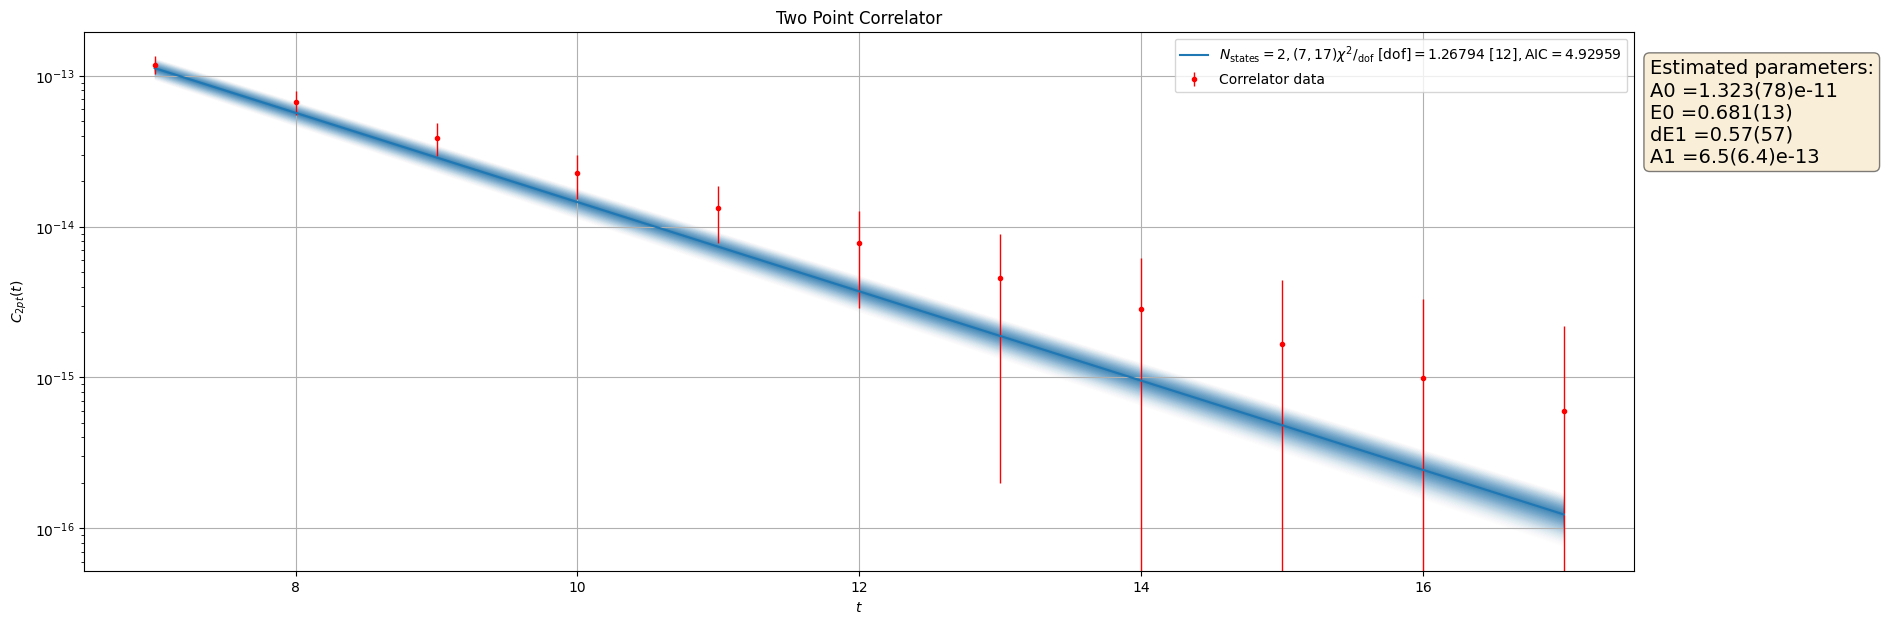

In [141]:
fit_result = ca.fit(

                    abscissa                = np.arange(t_start,t_end),
                    
                    ordinate_est            = np.mean(p2corr[:,t_start:t_end], axis = 0),
                    ordinate_std            = np.std (p2corr[:,t_start:t_end], axis = 0),
                    ordinate_cov            = np.cov (p2corr[:,t_start:t_end], rowvar=False),
                    
                    #resample_ordinate_est   = p2corr_resamples[:,t_start:t_end],
                    #resample_ordinate_std   = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    #resample_ordinate_cov   = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "jkn",

                    # args for lsqfit:
                    model   = SumOrderedExponentials(2),
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
)

C = gv.gvar( np.mean(p2corr[:,fit_result.ts:fit_result.te], axis = 0), np.std(p2corr[:,fit_result.ts:fit_result.te], axis = 0))

plot_fit_corr(fit_result=fit_result,correlator=C, nstates=2)

# Lowering $t_{start}$

In [145]:
#we define the parameters of interest
nstates_list = [1,2]
t_start_list = np.arange(t_start, int(t_start/2), -1)


t_start
t_start_list

7

array([7, 6, 5, 4])

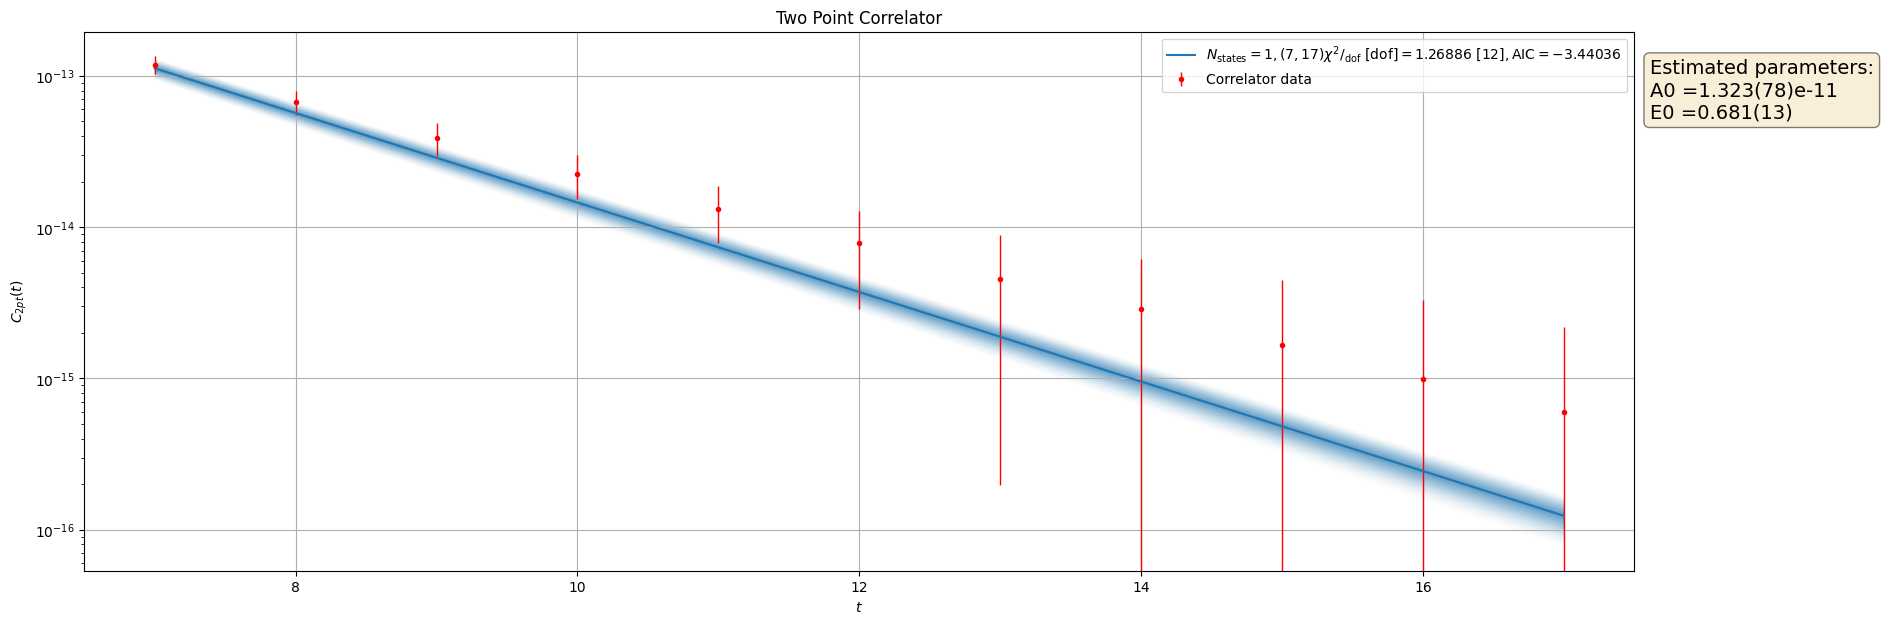

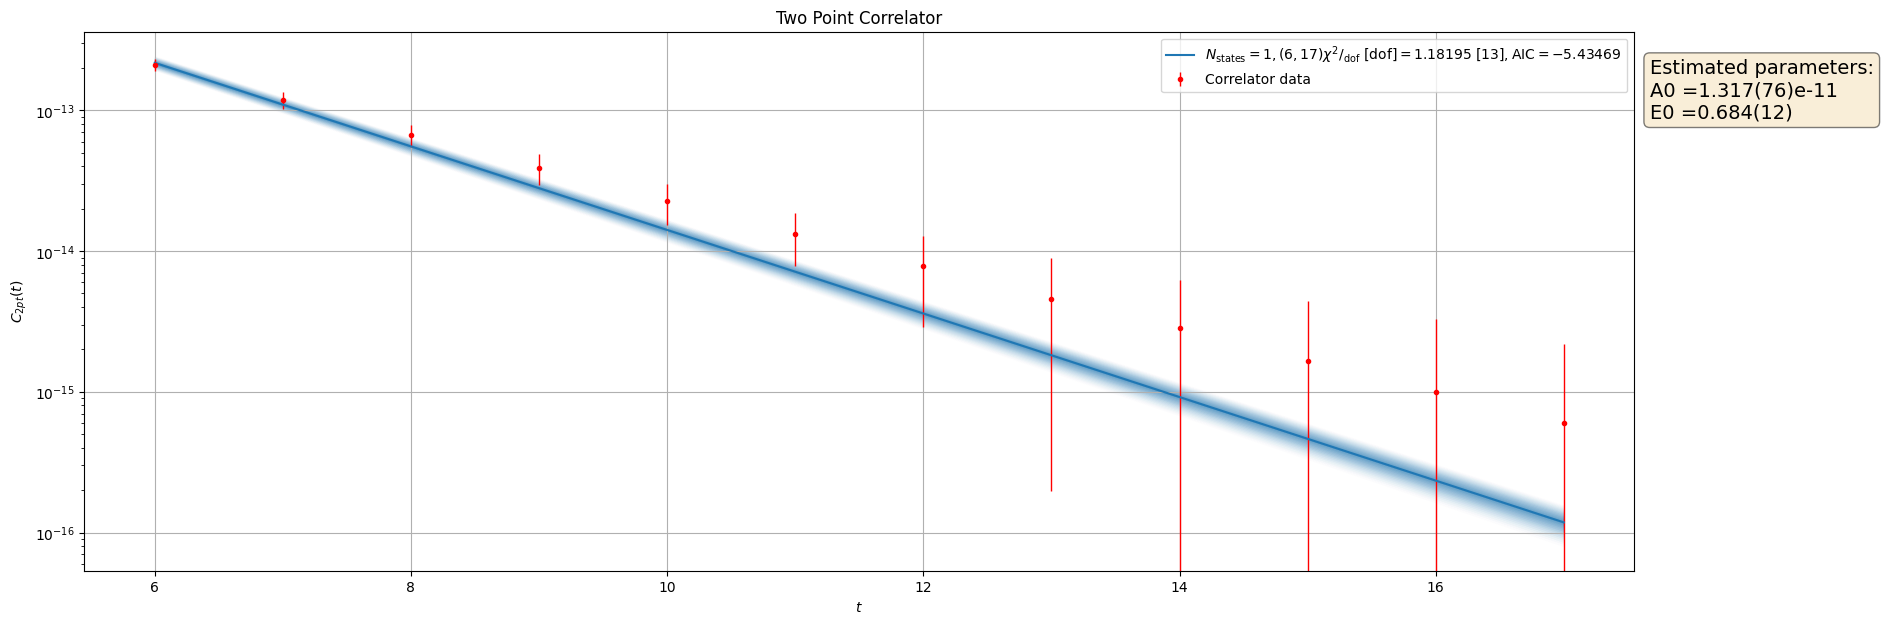

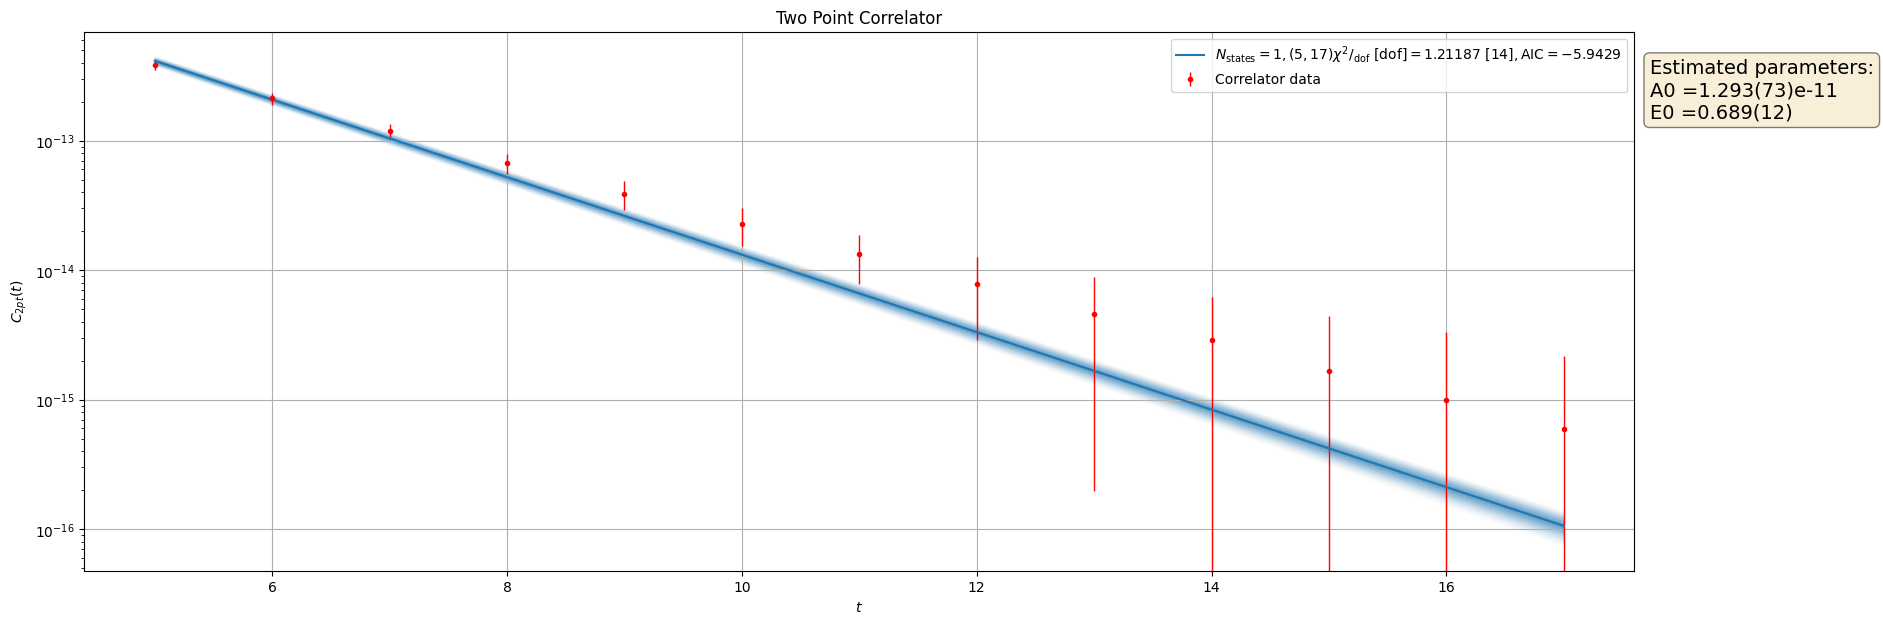

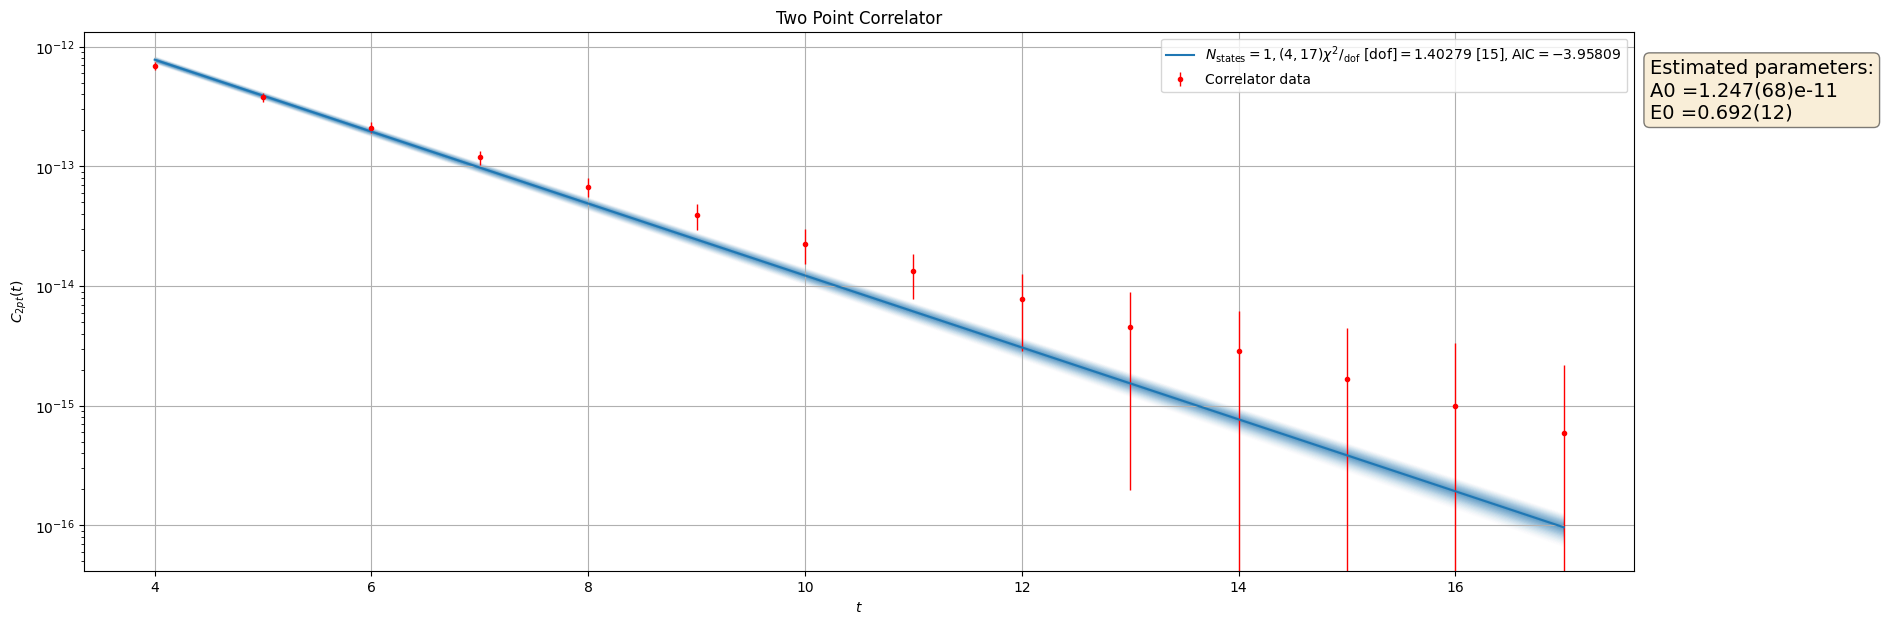

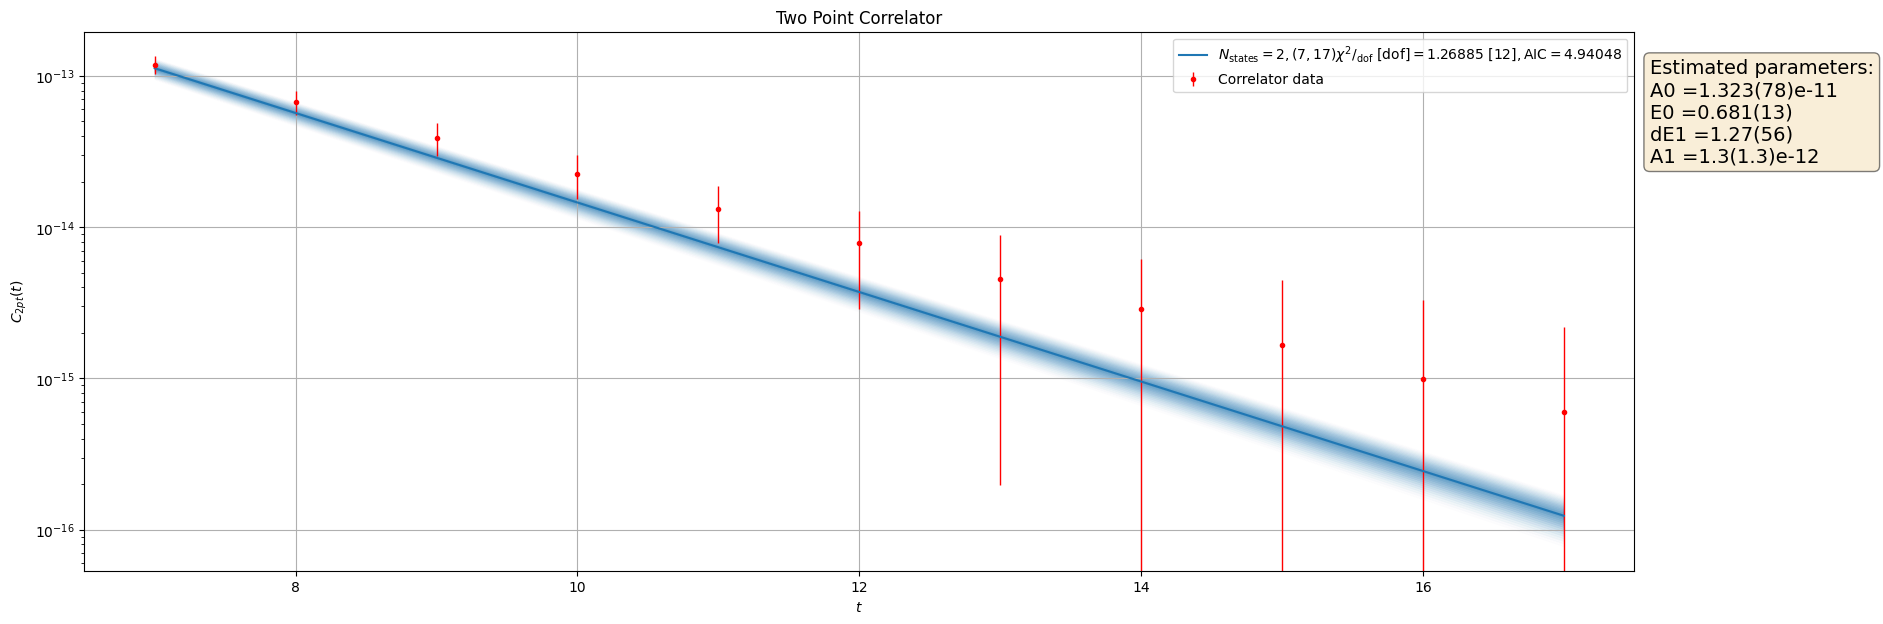

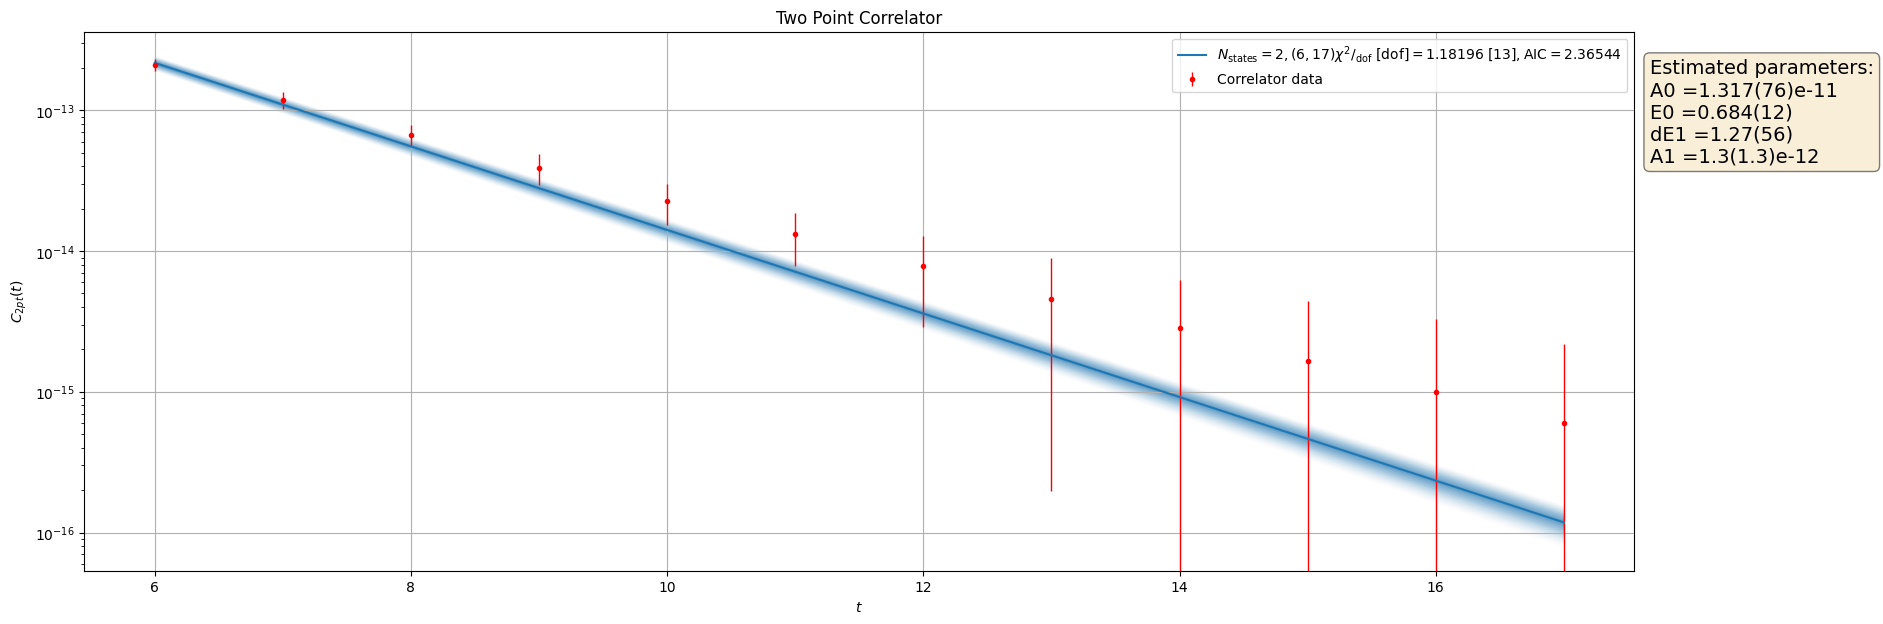

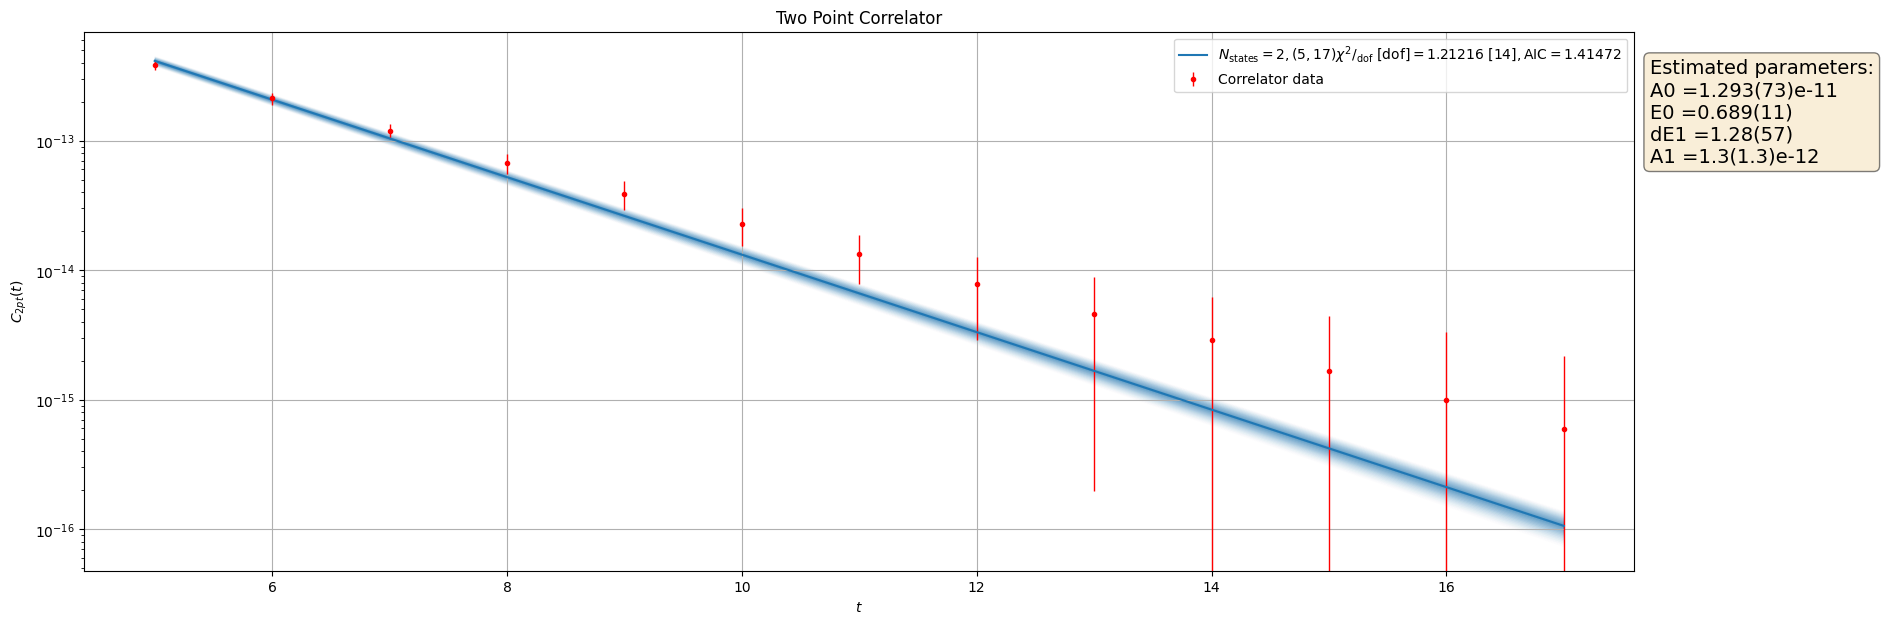

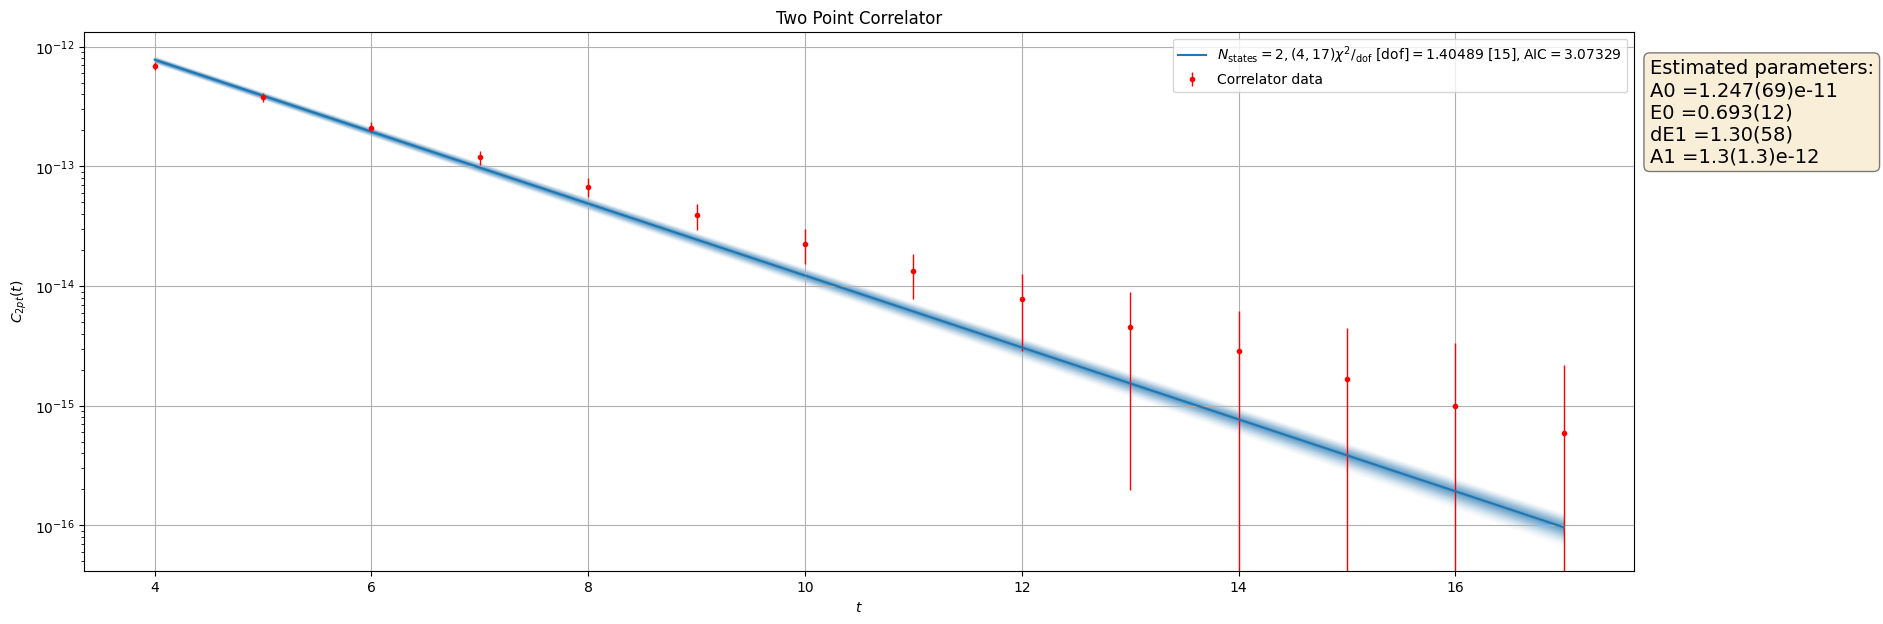

In [154]:
#meff studied --> tstart and tend determined


fit_state = ca.FitState()


#loop over params
for i_st, nstates in enumerate(nstates_list):

    # --> prior determination

    prior = gv.BufferDict()

    prior["A0"] = gv.gvar(Afit,Afit_std * 10)
    prior["E0"] = gv.gvar(mfit, mfit_std * 10)
    #prior["A1"] = gv.gvar(1,1000)
    #prior["log(dE1)"] = gv.log(gv.gvar(1,1))

    if nstates==2:


        prior[f"log(dE1)"]= gv.log(prior["E0"] + gv.gvar(
                    gv.mean(m_prot),
                    gv.mean(m_prot),
                ))

        t_probe = 1
        tmp = (np.mean(p2corr,axis=0)[t_probe] - prior["A0"] * np.exp(-t_probe*prior["E0"]) ) * np.exp( t_probe * ( prior["dE1"] + prior["E0"]) )
        prior[f"A1"] = gv.gvar( 
            gv.mean(tmp),gv.mean(tmp)
        )       

    for i_ts, t_start in enumerate(t_start_list):

        # --> do the fit
        
        fit_result = ca.fit(

                    abscissa                = np.arange(t_start,t_end),
                    
                    ordinate_est            = np.mean(p2corr[:,t_start:t_end], axis = 0),
                    ordinate_std            = np.std (p2corr[:,t_start:t_end], axis = 0),
                    ordinate_cov            = np.cov (p2corr[:,t_start:t_end], rowvar=False),
                    
                    #resample_ordinate_est   = p2corr_resamples[:,t_start:t_end],
                    #resample_ordinate_std   = np.std (p2corr_resamples[:,t_start:t_end], axis = 0),
                    #resample_ordinate_cov   = np.cov (p2corr_resamples[:,t_start:t_end], rowvar=False),

                    # fit strategy, default: only uncorrelated central value fit:
                    central_value_fit            = True,
                    central_value_fit_correlated = False,

                    resample_fit                 = False,
                    resample_fit_correlated      = False,
                    
                    resample_fit_resample_prior  = False,
                    resample_type               = "jkn",

                    # args for lsqfit:
                    model   = SumOrderedExponentials(nstates),
                    prior   = prior,
                    p0      = None,

                    svdcut  = None,
                    maxiter = 10_000,
                )
        
        C = gv.gvar( np.mean(p2corr[:,fit_result.ts:fit_result.te], axis = 0), np.std(p2corr[:,fit_result.ts:fit_result.te], axis = 0))

        plot_fit_corr(fit_result=fit_result,correlator=C, nstates=nstates, Ngrad=15)

        fit_state.append(fit_result)

In [155]:
fit_state

FitState(fit_results=[FitResult[ (5,18), resample:False]:
  𝜒²/dof [dof] = 1.21 [14]
  AIC = -5.94 
    - A0: 1.293(73)e-11  [1.248(82)e-11]
    - E0: 0.689(12)  [0.742(21)]
, FitResult[ (6,18), resample:False]:
  𝜒²/dof [dof] = 1.18 [13]
  AIC = -5.43 
    - A0: 1.317(76)e-11  [1.248(82)e-11]
    - E0: 0.684(12)  [0.742(21)]
, FitResult[ (4,18), resample:False]:
  𝜒²/dof [dof] = 1.4 [15]
  AIC = -3.96 
    - A0: 1.247(68)e-11  [1.248(82)e-11]
    - E0: 0.692(12)  [0.742(21)]
, FitResult[ (7,18), resample:False]:
  𝜒²/dof [dof] = 1.27 [12]
  AIC = -3.44 
    - A0: 1.323(78)e-11  [1.248(82)e-11]
    - E0: 0.681(13)  [0.742(21)]
, FitResult[ (5,18), resample:False]:
  𝜒²/dof [dof] = 1.21 [14]
  AIC = 1.41 
    - A0: 1.293(73)e-11  [1.248(82)e-11]
    - E0: 0.689(11)  [0.742(21)]
    - dE1: 1.28(57)  [1.33(59)]
    - A1: 1.3(1.3)e-12  [1.3(1.3)e-12]
, FitResult[ (6,18), resample:False]:
  𝜒²/dof [dof] = 1.18 [13]
  AIC = 2.37 
    - A0: 1.317(76)e-11  [1.248(82)e-11]
    - E0: 0.684(12)  

In [161]:
fit_state.model_average()

for key in fit_state.model_average()["est"].keys():
    key
    gv.gvar(fit_state.model_average()["est"][key], fit_state.model_average()["err"][key])


{'est': {'A0': np.float64(1.2971017545650672e-11),
  'E0': np.float64(0.6868863514053016),
  'dE1': np.float64(1.283343611854306),
  'A1': np.float64(1.3441007345572609e-12)},
 'err': {'A0': np.float64(4.0053119329106783e-13),
  'E0': np.float64(0.006314372516356154),
  'dE1': np.float64(0.32278522091746414),
  'A1': np.float64(7.67047861646298e-13)}}

'A0'

1.297(40)e-11

'E0'

0.6869(63)

'dE1'

1.28(32)

'A1'

1.34(77)e-12

In [162]:
gv.gvar(fit_state.model_average()["est"]["E0"], fit_state.model_average()["err"]["E0"]) /a * 197.327

1165(11)